In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np 
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import models,datasets
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from torch.optim import lr_scheduler

In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

device = torch.device("cuda:0" if USE_GPU else "cpu")

using device: cuda


In [3]:
#HYPERPARAMETERS
BATCH_SIZE = 128

In [4]:
train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [8]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [9]:
!kaggle datasets download -d jerzydziewierz/bee-vs-wasp

bee-vs-wasp.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
!ls

bee-vs-wasp.zip  kaggle_bee_vs_wasp  kaggle.json


In [11]:
import zipfile

with zipfile.ZipFile("/content/gdrive/MyDrive/Kaggle/bee-vs-wasp.zip","r") as zip_ref:
    zip_ref.extractall(".")

In [12]:
parent_dir = '/content/gdrive/MyDrive/Kaggle/kaggle_bee_vs_wasp'
print(os.listdir(parent_dir))

['bee1', 'README.md', 'bee2', 'example_notebook', 'label_generator', 'labels.csv', 'other_insect', 'other_noinsect', 'wasp1', 'wasp2']


In [13]:
#Create a list of bee files
bee1 = '/content/gdrive/MyDrive/Kaggle/kaggle_bee_vs_wasp/bee1'
bee2 = '/content/gdrive/MyDrive/Kaggle/kaggle_bee_vs_wasp/bee2'
bee_list = os.listdir(bee1)
print(len(bee_list))
for i in os.listdir(bee2):
    bee_list.append(i)
print(bee1.split('/')[-1])

#Create a list of wasp files
wasp1 = '/content/gdrive/MyDrive/Kaggle/kaggle_bee_vs_wasp/wasp1'
wasp2 = '/content/gdrive/MyDrive/Kaggle/kaggle_bee_vs_wasp/wasp2'
wasp_list = os.listdir(wasp1)
print(len(wasp_list))
for i in os.listdir(wasp2):
    wasp_list.append(i)
print(len(wasp_list))

oi = '/content/gdrive/MyDrive/Kaggle/kaggle_bee_vs_wasp/other_insect'
oi_list = os.listdir(oi)
print(len(oi_list))

oni = '/content/gdrive/MyDrive/Kaggle/kaggle_bee_vs_wasp/other_noinsect'
oni_list = os.listdir(oni)
print(len(oni_list))

2469
bee1
2127
4943
2439
856


In [14]:
class BeeWaspDataset(Dataset):
    def __init__(self, filelist,directory,transform = None):
        self.filelist = filelist
        self.directory = directory
        self.transform = transform
    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self,idx):
        img =  Image.open(os.path.join(self.directory, self.filelist[idx]))
        img = img.convert('RGB')
        img = self.transform(img)
        
        if 'bee1' in self.directory.split('/')[-1]:
            self.label = 0
        elif 'bee2' in self.directory.split('/')[-1]:
            self.label = 0
        elif 'wasp1' in self.directory.split('/')[-1]:
            self.label = 1
        elif 'wasp2' in self.directory.split('/')[-1]:
            self.label = 1
        elif 'other_insect' in self.directory.split('/')[-1]:
            self.label = 2
        elif 'other_noinsect' in self.directory.split('/')[-1]:
            self.label = 3
        
        img = img.numpy()
        return img.astype('float32'), self.label

In [15]:
classes = ['bee1','bee2','wasp1','wasp2','other_insect','other_noinsect']
working_ds = None
for c in classes:
    directory = os.path.join(parent_dir,c)
    file_list = os.listdir(directory)
    new = BeeWaspDataset(file_list,directory,train_transform)
    
    if working_ds == None:
        working_ds = new
    else:
        working_ds = ConcatDataset([working_ds,new])
print(len(working_ds))

11421


In [16]:
def train_val_split(working_ds):
    val_split = 0.05
    l = float(len(working_ds))
    m = int(val_split*l)
    train_ds,val_ds = random_split(working_ds,[int(l)-m,m])
    return train_ds,val_ds

In [24]:
  from sklearn.model_selection import KFold
  train_ds,val_ds = train_val_split(working_ds)
  k_folds = 5
  kfold = KFold(n_splits=k_folds, shuffle=True)
 # K-fold Cross Validation model evaluation
  for fold, (train_ids, test_ids) in enumerate(kfold.split(working_ds)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    train_loader = torch.utils.data.DataLoader(
                      working_ds, 
                      batch_size=BATCH_SIZE, sampler=train_subsampler)
    test_loader = torch.utils.data.DataLoader(
                      working_ds,
                      batch_size=BATCH_SIZE, sampler=test_subsampler)
    

FOLD 0
--------------------------------
FOLD 1
--------------------------------
FOLD 2
--------------------------------
FOLD 3
--------------------------------
FOLD 4
--------------------------------


In [25]:
for i,l in train_loader:
    c = 0
    c= c+1
    print(l)
    if c == 1:
        break

tensor([2, 1, 2, 2, 1, 0, 1, 2, 2, 0, 1, 1, 1, 1, 0, 1, 2, 0, 1, 2, 1, 0, 0, 1,
        1, 0, 0, 2, 0, 1, 1, 1, 2, 0, 1, 1, 1, 0, 0, 2, 1, 1, 1, 0, 2, 0, 0, 1,
        1, 0, 1, 0, 0, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 0, 0, 1, 2, 3, 3, 1,
        1, 2, 1, 1, 0, 1, 1, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 3, 1, 2, 0, 1,
        1, 2, 1, 0, 1, 0, 3, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


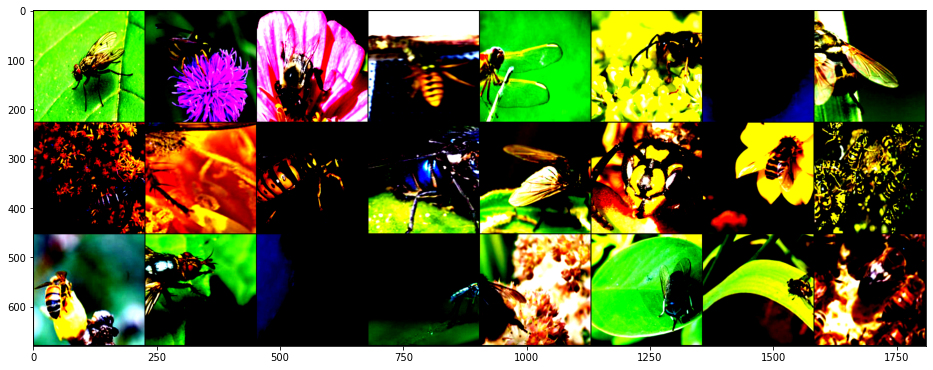

In [26]:
import matplotlib.pyplot as plt
import numpy
samples, labels = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

In [27]:
def model_eval(dataloader,model):
    total = 0
    correct = 0
    for data in dataloader:
      images, l = data
      
      images = images.to(device)
      l = l.to(device)
      
      out = model(images)
      max_val, preds = torch.max(out,dim=1)
      
      total += l.shape[0]                   
      correct += (preds == l).sum().item()  
      accuracy = (100 * correct)/total
    
    
    return accuracy

In [28]:
fe = models.resnet18(pretrained=True)
i = 0
for param in fe.parameters():
    i = i+1
    if (i>=4):
        param.requires_grad = True
    else:
        param.requires_grad = False
num_ftrs = fe.fc.in_features
class ResNet18(nn.Module):
  def __init__(self):
    super(ResNet18, self).__init__()
    self.features = torch.nn.Sequential(*list(fe.children())[:-1])
    
    self.drop1 = nn.Dropout(0.3)
    self.fc1 = nn.Linear(num_ftrs,128)
    self.drop2 = nn.Dropout(0.2)
    self.fc2 = nn.Linear(128,4)
    #We did not add a softmax layer here because the CrossEntropy Loss function contains a softmax, so if you want 
    #to test output, you will have to add a softmax block in addition to the model block
    
  def forward(self,x):
    x = self.features(x)
    
    x = x.view(x.shape[0],512)
    
    x = self.drop1(x)
    x = F.relu(self.fc1(x))
    x = self.drop2(x)
    x = F.relu(self.fc2(x))
    
    
    
    return x  

resnet_model = ResNet18()
resnet_model = resnet_model.to(device)


print(resnet_model)  

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet18(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr= 3.613306260989238e-05)
sch = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
scaler = torch.cuda.amp.GradScaler()
NUM_EPOCHS = 15
acc_log = []

In [30]:
!pip install optuna

     |████████████████████████████████| 296kB 24.8MB/s 
     |████████████████████████████████| 163kB 55.8MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
     |████████████████████████████████| 81kB 12.4MB/s 
     |████████████████████████████████| 143kB 57.9MB/s 
     |████████████████████████████████| 112kB 59.1MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=0e96bb18328c1c66395fcf09665389fe27ddd26c7b8e405eeb8eb79a8d9ff548
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [43]:
import optuna
from tqdm import tqdm
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=5e-6)
sch = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
scaler = torch.cuda.amp.GradScaler()
NUM_EPOCHS = 8
def objective(trial):
    lr =  trial.suggest_float("learning_rate",1e-7,1e-3,log = True)
    opt = trial.suggest_categorical("optimizer",["SGD","Adam","RMSprop"])
    optimizer = getattr(optim, opt)(resnet_model.parameters(), lr=lr)
    for epoch in range(NUM_EPOCHS):
        resnet_model.train()
        running_loss = 0.0
        history =[]
        #loop = tqdm(train_loader)
        for i,data in enumerate(train_loader):
            inputs,labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.cuda.amp.autocast():
              output = resnet_model(inputs).to(device)
              loss = criterion(output, labels)
            
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            #loop.set_postfix(loss = loss.item())
            #running_loss += loss
            #history.append(loss)
            
        
        resnet_model.eval()
        accuracy = model_eval(test_loader, resnet_model)
        trial.report(accuracy,epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return accuracy

In [44]:
if __name__== "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50)
    pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

    print("Study Stats: ")
    print("Number of finished trials ", len(study.trials))
    print("Number of pruned trials ", len(pruned_trials))
    print("Number of complete trials ", len(complete_trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2021-05-01 10:35:26,405] A new study created in memory with name: no-name-60e10fad-cff2-43e0-baf7-10bc1d85b40d
[I 2021-05-01 10:48:27,165] Trial 0 finished with value: 87.43432574430823 and parameters: {'learning_rate': 0.0003025064099682346, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 87.43432574430823.
[I 2021-05-01 11:01:24,013] Trial 1 finished with value: 92.07530647985989 and parameters: {'learning_rate': 0.0001475758888427574, 'optimizer': 'SGD'}. Best is trial 1 with value: 92.07530647985989.
[I 2021-05-01 11:14:18,167] Trial 2 finished with value: 92.81961471103328 and parameters: {'learning_rate': 2.052568686790385e-06, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 92.81961471103328.
[I 2021-05-01 11:27:11,436] Trial 3 finished with value: 91.9001751313485 and parameters: {'learning_rate': 0.00013987754714540359, 'optimizer': 'Adam'}. Best is trial 2 with value: 92.81961471103328.
[I 2021-05-01 11:40:03,462] Trial 4 finished with value: 92.11908931698774 an

Study Stats: 
Number of finished trials  50
Number of pruned trials  32
Number of complete trials  18
Best trial:
  Value:  94.22066549912434
  Params: 
    learning_rate: 4.0141392523896525e-05
    optimizer: RMSprop


In [47]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(resnet_model.state_dict(), path)

In [49]:
optuna.visualization.plot_contour(
    study, params = ["learning_rate", "optimizer"]
)

In [54]:
optuna.visualization.plot_optimization_history(study)

In [55]:
optuna.visualization.plot_param_importances(
    study, params = ["learning_rate", "optimizer"]
)

In [57]:
optuna.visualization.plot_edf(
    study
)